Implement the origial [Nagel-Schreckenberg model of freeway traffic](https://en.wikipedia.org/wiki/Nagel%E2%80%93Schreckenberg_model):
1. Run the model for different probabilities $p$ of slowing down.
2. Plot the average velocity as a function of the density $\rho$ of cars per cell for different values of $p$.
3. Visualize the evolution of the system for $p = 0.3$ and $\rho = 0.1$, $0.2$, $0.6$.
4. (optional) Add a second lane (in the same direction) to the model and a rule that allows overtaking. Compare the results for the average velocity with the previous case.

*Importing all necessary libraries*

In [1]:
import random
import numpy as np
import matplotlib
import matplotlib.animation
import matplotlib.pyplot as plt
import IPython.display
from tqdm.notebook import tqdm

*Fine-tuning plotting settings*

In [2]:
matplotlib.rcParams['figure.figsize'] = [20, 10]
matplotlib.rc('font', family='Lato', size=16)

First we implement class, which will represent the cars:

In [3]:
class Car:
    def __init__(self, speed, max_speed):
        self.speed = speed
        self.max_speed = max_speed
    
    def __repr__(self):
        return f"Car(speed={self.speed})"
    
    def copy(self):
        return Car(self.speed, self.max_speed)

And a class representing the track (with periodic boundary conditions):

In [4]:
EMPTY_CELL = -10  # Value for encoding an empty cell

class PeriodicTrack:
    def __init__(self, array):
        self._array = array
        
    def __getitem__(self, index):
        index = self._wrap_index(index)
        return self._array.__getitem__(index)
    
    def __setitem__(self, index, value):
        index = self._wrap_index(index)
        return self._array.__setitem__(index, value)
    
    def __iter__(self):
        return self._array.__iter__()
    
    def __repr__(self):
        return self._array.__repr__()
    
    def __len__(self):
        return self._array.__len__()
    
    @staticmethod
    def random_track(length, n_cars, vmin=1, vmax=5):
        list_ = [None for _ in range(length)]
        indicies = random.sample(range(length), n_cars)
        for index in indicies:
            list_[index] = Car(random.randint(vmin, vmax), vmax)
        return PeriodicTrack(list_)
    
    @staticmethod
    def empty(length):
        return PeriodicTrack([None for _ in range(length)])
    
    def _wrap_index(self, index):
        _len = len(self._array)
        return (index % _len + _len) % _len
    
    def copy(self):
        return PeriodicTrack(self._array.copy())
    
    def distance_to_next_obj(self, index):
        dist = 0
        i = index + 1
        while self[i] is None:
            dist += 1
            i += 1
        return dist
    
    def average_velocity(self):
        speeds = [car.speed for car in self if isinstance(car, Car)]
        if speeds:
            return np.mean(speeds)
        else:
            return 0
    
    def to_matrix(self):
        return np.atleast_2d([EMPTY_CELL if car is None else car.speed for car in self])
    
    def plot(self):
        _matrix = self.to_matrix()
        plt.imshow(_matrix, vmin=EMPTY_CELL)
        # The grid.
        plt.gca().set_xticks([_ + .5 for _ in range(_matrix.shape[1])], minor='true')
        plt.grid(alpha=1, color='white', which='minor')
        # The numbers.
        for (x, y), value in np.ndenumerate(_matrix):
            if value >= 0:
                plt.text(y, x, value, va='center', ha='center')
        
        plt.xticks([])
        plt.yticks([])
        plt.show()

Then the last thing we need will be a function that takes current track and returns new one after a one iteration.

In [5]:
def update_track(track, slowing_prob=0.5):
    track = track.copy()
    new_track = PeriodicTrack.empty(len(track))
    for i, car in enumerate(track):
        if not car is None:
            # 1. Acceleration
            car.speed = min(car.speed + 1, car.max_speed)
            # 2. Slowing down to not hit cars in front
            track[i] = Car(min(track.distance_to_next_obj(i), car.speed), car.max_speed)
            # 3. Random slowing down
            if np.random.rand() < slowing_prob and track[i].speed >= 1:
                track[i].speed -= 1
    # 4. Moving the cars
    for i, car in enumerate(track):
        if not car is None:
            new_track[i + car.speed] = car
    return new_track

Let's creat a simple track, display it at the beginning and after one iteration.

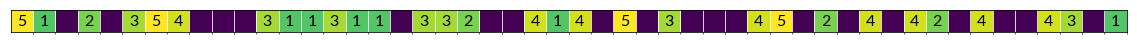

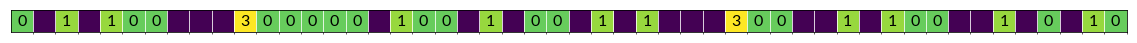

In [17]:
track = PeriodicTrack.random_track(50, 30)
track.plot()
track = update_track(track)
track.plot()

As we can see everything looks good, vehicles with something in front of them have to slow down absolutely while other can move and sometimes even accelerate!

# Animation

To create the animation we generete new track and append it to the list of tracks.

In [7]:
track = PeriodicTrack.random_track(100, 35)

In [8]:
tracks = []
tracks.append(track)

Next we define number of iterations and run the simulation.

In [9]:
N_ITERATIONS = 100
for _ in range(N_ITERATIONS):
    track = update_track(track, slowing_prob=0.3)
    tracks.append(track)

Now we will generate an anmiation from those tracks.

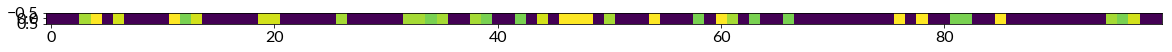

In [10]:
fig, ax = plt.subplots()
image = ax.imshow(tracks[0].to_matrix())

In [11]:
frame_counter = 0
def update_animation(frame):
    global frame_counter
    image.set_array(tracks[frame_counter].to_matrix())
    frame_counter = (frame_counter + 1) % len(tracks)

In [12]:
anim = matplotlib.animation.FuncAnimation(fig, update_animation, frames=len(tracks), interval=250)

In [13]:
IPython.display.HTML(anim.to_jshtml())

## Matrix visualization

As we are dealing with one dimensions - one spatial and one temporal - we can visualize evolution of the system as a matrix. Horizontal dimension will represent the positions of cars with color intensity corresponding the their speed. Vertical axis will represent time. (The cars move from left to right).

In [14]:
matrix = np.array([track.to_matrix().flatten() for track in tracks])

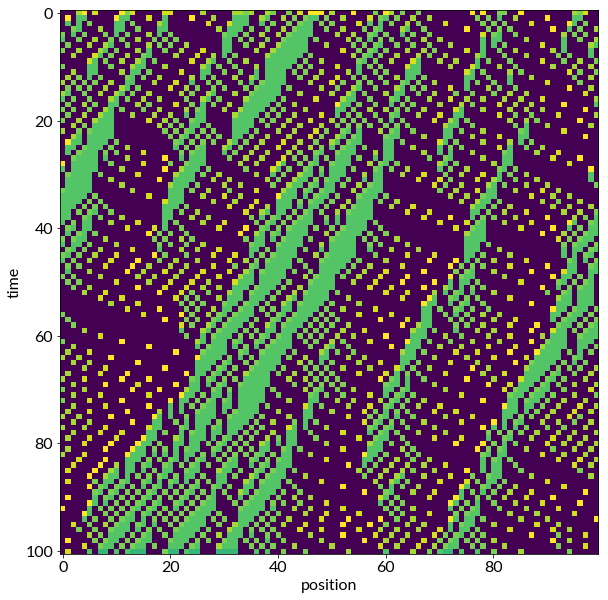

In [15]:
plt.imshow(matrix)
plt.xlabel('position')
plt.ylabel('time')
plt.show()

As we can see the initial, random, state quickly changes into multiple smaller traffic jams which are moving backward in space when the time progresses.

## Average velocity as a function of density $\rho$ and probability $p$.
Plot the average velocity as a function of the density $\rho$ of cars per cell for different values of $p$.

In [143]:
N = 100
N_ITER = 20
MC_AVERAGING = 50
rhos = np.linspace(0.01, 1, num=30)
ps = np.arange(0.1, 0.9, 0.1)

In [144]:
average_velocities = {p: [] for p in ps}
for p in tqdm(ps):
    for rho in rhos:
        track = PeriodicTrack.random_track(N, int(rho * N))
        tmp = []
        for i in range(MC_AVERAGING):
            inner_velocities = []
            for j in range(N_ITER):
                inner_velocities.append(track.average_velocity())
                track = update_track(track, slowing_prob=p)
            tmp.append(np.mean(inner_velocities) if inner_velocities else 0)
        average_velocities[p].append(np.mean(tmp))

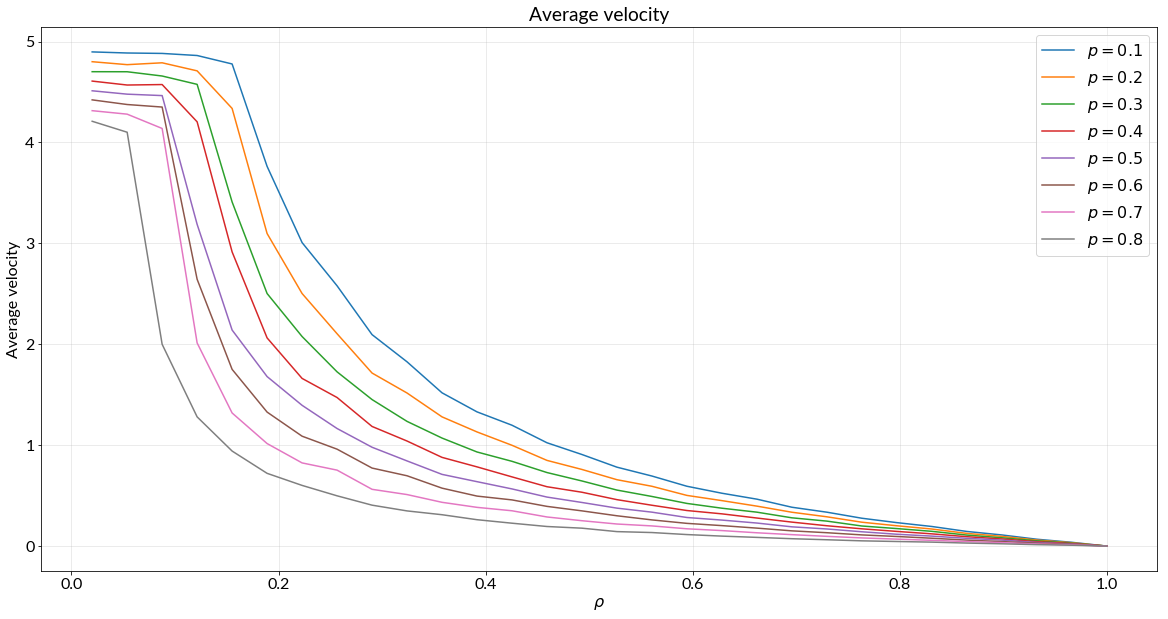

In [152]:
for p, average_velocity in average_velocities.items():
    plt.plot(rhos, average_velocity, label=f"$p={np.round(p, 2)}$")
plt.xlabel(r'$\rho$')
plt.ylabel(r'Average velocity')
plt.grid(alpha=0.3)
plt.title('Average velocity')
plt.legend()
plt.show()

## Visalization of the system for $p=0.3$ and $\rho=0.1$, $0.2$, $0.6$.

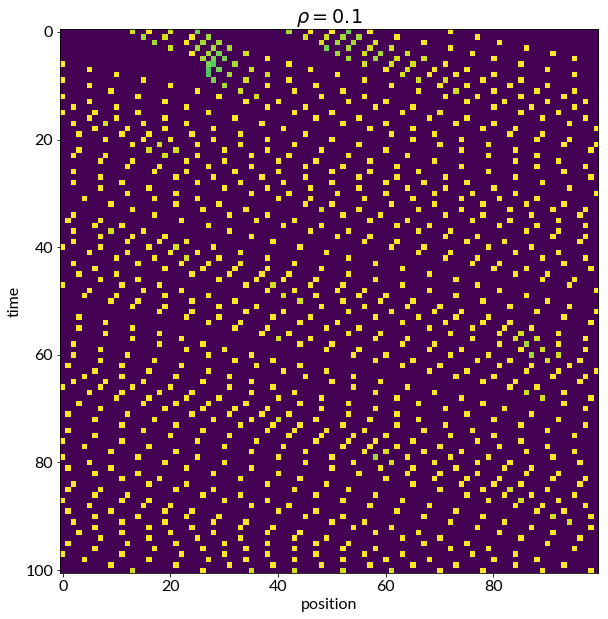

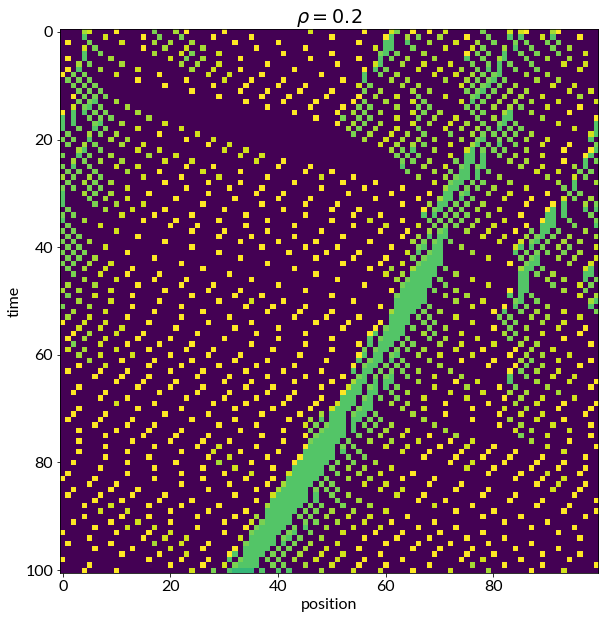

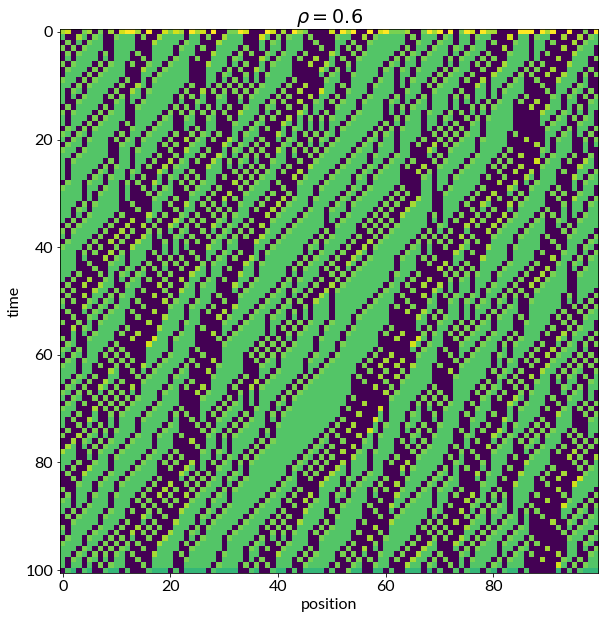

In [16]:
N_ITER = 100

for rho in [0.1, 0.2, 0.6]:
    track = PeriodicTrack.random_track(100, int(rho * 100))
    tracks = [track]
    for _ in range(N_ITERATIONS):
        track = update_track(track, slowing_prob=0.3)
        tracks.append(track)
    matrix = np.array([track.to_matrix().flatten() for track in tracks])
    
    plt.imshow(matrix)
    plt.xlabel("position")
    plt.ylabel("time")
    plt.title(f"$\\rho={rho}$")
    plt.show()

## Addition of a second lane.

We create another class...

In [147]:
class TwoLanePeriodicTrack:
    def __init__(self, track1, track2):
        self.track1 = track1
        self.track2 = track2    
        
    def copy(self):
        return TwoLanePeriodicTrack(self.track1.copy(), self.track2.copy())
    
    @staticmethod
    def empty(length):
        return TwoLanePeriodicTrack(
            PeriodicTrack.empty(length),
            PeriodicTrack.empty(length)
        )
    
    @staticmethod
    def random_track(length, n_cars):
        return TwoLanePeriodicTrack(
            PeriodicTrack.random_track(length, n_cars // 2),
            PeriodicTrack.random_track(length, n_cars // 2)
        )
    
    def __iter__(self):
        return zip(self.track1, self.track2)
    
    def __len__(self):
        return max(len(self.track1), len(self.track2))
    
    def plot(self):
        self.track1.plot()
        self.track2.plot()
        
    def average_velocity(self):
        return (self.track1.average_velocity() + self.track2.average_velocity()) / 2

And update function (this time more complex)...

In [148]:
def update_two_lane_track(tl_track, slowing_prob=0.5):
    tl_track = tl_track.copy()
    new_track1 = PeriodicTrack.empty(len(tl_track))
    new_track2 = PeriodicTrack.empty(len(tl_track))
    for i, (car1, car2) in enumerate(tl_track):
        # 1. Acceleration
        if car1:
            car1.speed = min(car1.speed + 1, car1.max_speed)
        if car2:
            car2.speed = min(car2.speed + 1, car2.max_speed)
        # 2. Checking number of cars in front in both lanes.
        l1_empty = tl_track.track1.distance_to_next_obj(i)
        l2_empty = tl_track.track2.distance_to_next_obj(i)
        # 3. Chaning the lanes.
        if car1 and not car2:
            if l2_empty > l1_empty:
                new_track2[i] = car1.copy()
            else:
                new_track1[i] = car1.copy()
        
        if car2 and not car1:
            if l1_empty > l2_empty:
                new_track1[i] = car2.copy()
            else:
                new_track2[i] = car2.copy()
                
        if car1 and car2:
            new_track1[i] = car1.copy()
            new_track2[i] = car2.copy()
    
    # 4. Slowing down to not hit cars in front and random slowing down.
    for i in range(len(tl_track)):
        if new_track1[i]:
            speed = min(new_track1.distance_to_next_obj(i), new_track1[i].speed)
            if np.random.rand() < slowing_prob and speed >= 1:
                speed -= 1
            new_track1[i] = Car(speed, new_track1[i].max_speed)
        if new_track2[i]:
            speed = min(new_track2.distance_to_next_obj(i), new_track2[i].speed)
            if np.random.rand() < slowing_prob and speed >= 1:
                speed -= 1
            new_track2[i] = Car(speed, new_track2[i].max_speed)
            
            
    # 6. Moving the cars
    newest_track1 = PeriodicTrack.empty(len(new_track1))
    for i, car in enumerate(new_track1):
        if car:
            newest_track1[i + car.speed] = car
            
    newest_track2 = PeriodicTrack.empty(len(new_track2))
    for i, car in enumerate(new_track2):
        if car:
            newest_track2[i + car.speed] = car
    
    return TwoLanePeriodicTrack(newest_track1, newest_track2)

We show how it works...

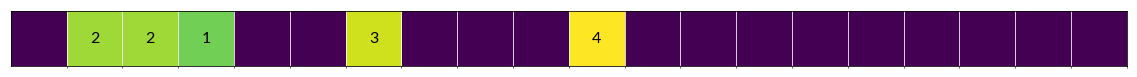

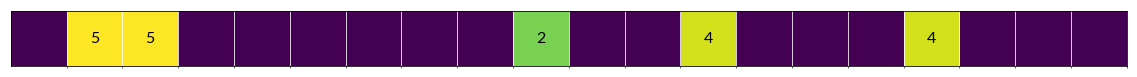

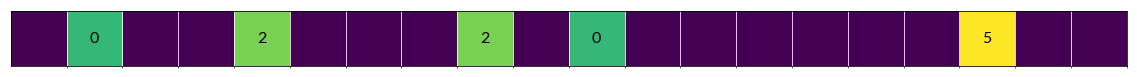

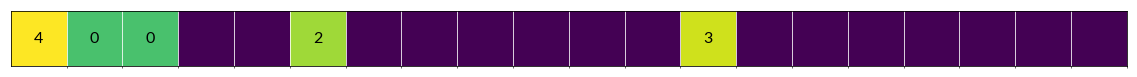

In [149]:
two_lane = TwoLanePeriodicTrack.random_track(20, 10)
two_lane.plot()

two_lane = update_two_lane_track(two_lane)

two_lane.plot()

### Average velocity for two lane road.

Same as before but for different tracks (two lane) and appropriate update function.

In [157]:
N = 100
N_ITER = 20
MC_AVERAGING = 50
rhos = np.linspace(0.02, 1, num=30)
ps = np.arange(0.1, 0.9, 0.1)

In [158]:
average_velocities = {p: [] for p in ps}
for p in tqdm(ps):
    for rho in rhos:
        track = TwoLanePeriodicTrack.random_track(N, int(rho * N))
        tmp = []
        for i in range(MC_AVERAGING):
            inner_velocities = []
            for j in range(N_ITER):
                inner_velocities.append(track.average_velocity())
                track = update_two_lane_track(track, slowing_prob=p)
            tmp.append(np.mean(inner_velocities) if inner_velocities else 0)
        average_velocities[p].append(np.mean(tmp))

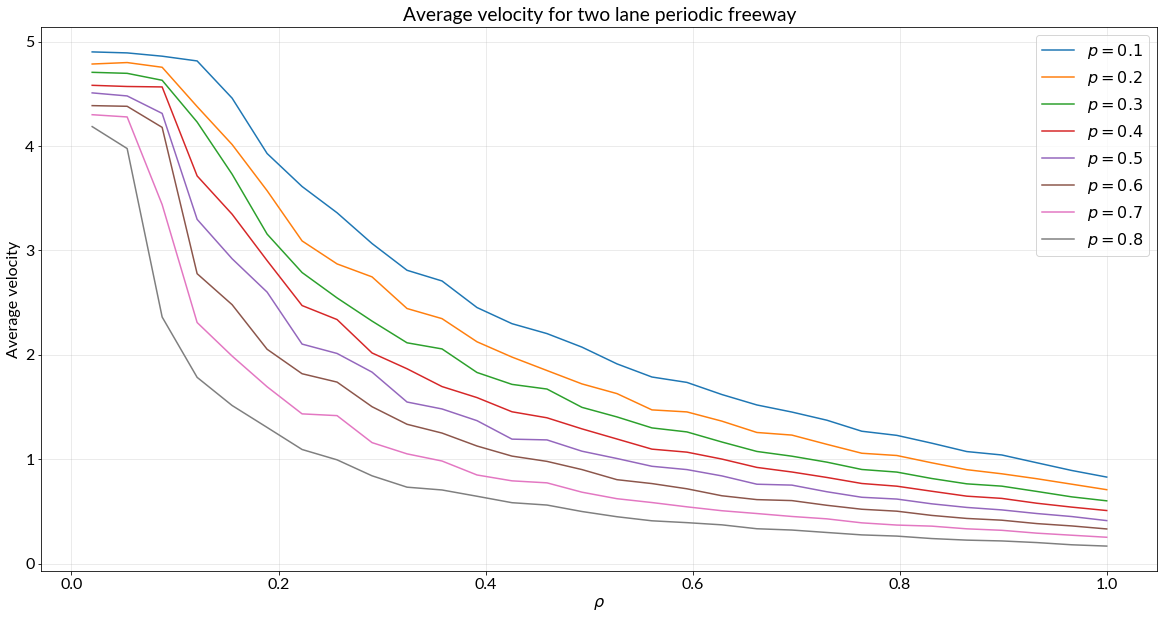

In [159]:
for p, average_velocity in average_velocities.items():
    plt.plot(rhos, average_velocity, label=f"$p={np.round(p, 2)}$")
plt.xlabel(r'$\rho$')
plt.ylabel(r'Average velocity')
plt.grid(alpha=0.3)
plt.title('Average velocity for two lane periodic freeway')
plt.legend()
plt.show()